In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
from os import getcwd

# Load facebook data
The dataset consists of the results of a real (anonymized) advertisement campaign on facebook: an media studio has created a set of ads posted on facebook, each ad was run for few days. There are several way in which a user can interact with an ad on facebook:

 1. At first the user is simply presented the ad post, while browsing the social media website or on the mobile app. This is called **reach**, the simple fact that the ad was shown to any given individual
 2. The user can show some interest on the ad and, for example, click on it. This is called **engagement**, clearly this has a higher value with respect the simple reach, because at least there is some interest from the user
 3. After viewing the ad the user can show even more interest, for example giving a **reaction**: thumb-up, smile etc. Knowing this has happened is even a stronger sign that the ad is reaching the correct audience
 4. Finally we consider a **share**, the act of sharing the ad, even a stronger sign of success: the user is so engaged that wants other contacts to know he likes the ad. The advertiser got free spread!

We expect that the number of people that share is smaller than the one give a reaction, that is smaller than the one showing engagement, that is probably a fraction (how much?) of the reached people. This hierarchy is usually called *funnel* and the goal of the creative and data scientist working on the ad campaign is to minimize the fraction of user *lost* at each step, *targeting* the advertising to the right audience.

Facebook allows to download very detailed metrics (the one mentioned here are an oversimplification of more than 200 metrics usually available). The goal of the exercise is to perform some simple reporting and show the success of the ad campaign for demographic groups: age groups, and gender. Age and sex are collected by facebook from the user profile, only aggregated data are available.

## Load data from Excel file
Data are stored in an excel file: `data/social_media.xlsx`, the excel sheet is called `AD_data`, the following code reads the file and loads the data into a `pandas.DataFrame`.

In [3]:
_datadir = join(getcwd(),'data')
_filename = 'social_media.xlsx' #Name of the excel file
_sheet = 'AD_data' #Name of the excel "sheet"
_xls = pd.ExcelFile(join(_datadir,_filename)) #Open Excel
df = pd.read_excel(_xls,_sheet,header=0) #Load sheet as dataframe

In [5]:
######
# Exercise 1: Inspeact some lines of the DataFrame
######
df.head()

date  ad_id    age   gender  reach  engagement  reactions  shares
0 2019-04-07     35  55-64     male    624         9.0        7.0     NaN
1 2019-04-07     35  55-64   female    464         4.0        2.0     NaN
2 2019-04-07     35  45-54  unknown      0         NaN        NaN     NaN
3 2019-04-07     35  45-54     male   8864       124.0       82.0     6.0
4 2019-04-07     35  45-54   female   5808        89.0       63.0     2.0

Each entry (row) has a time-stamp, the unique identifier of the ad that the entry refer to (more than one ad can run each day, and any ad can be shown for several days), the next column `age` is the age group, than there is the `gender` and finally counters for each metric. For example the very first row shown above means: on 7-Apr-2019 the ad with ID 35, was shown to 624 males aged 55-64. Only 9 of them interacted with it, 7 left a reaction, but nobody re-shared the ad.

# Clean and prepare data
The excel file has some missing values. The meaning of an *empty* cell is actually that there are no data available. 
First let's replace `nan`s with `0`s.

In [12]:
######
# Exercise 2: Use `pandas.DataFrame.fillna` function
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html
######
df.fillna(0, inplace=True) # df = df.fillna(0)
df.head(20)

date  ad_id    age   gender  reach  engagement  reactions  shares
0  2019-04-07     35  55-64     male    624         9.0        7.0     0.0
1  2019-04-07     35  55-64   female    464         4.0        2.0     0.0
2  2019-04-07     35  45-54  unknown      0         0.0        0.0     0.0
3  2019-04-07     35  45-54     male   8864       124.0       82.0     6.0
4  2019-04-07     35  45-54   female   5808        89.0       63.0     2.0
5  2019-04-07     35  35-44  unknown      0         0.0        0.0     0.0
6  2019-04-07     35  35-44     male  23568       251.0      191.0     2.0
7  2019-04-07     35  35-44   female   9232       129.0      102.0     4.0
8  2019-04-07     35  25-34  unknown     25         0.0        0.0     0.0
9  2019-04-07     35  25-34     male  36543       282.0      213.0     8.0
10 2019-04-07     35  25-34   female  11776       102.0       80.0     1.0
11 2019-04-05     36    65+  unknown      0         8.0        1.0     0.0
12 2019-04-05     36    65+     male  14719      5367.0       94.0    12.0
13 2019-04-05     36    65+   female   3594      1154.0       23.0     1.0
14 2019-04-05     36  55-64  unknown      0         1.0        0.0     0.0
15 2019-04-05     36  55-64     male  41342     14383.0      261.0    46.0
16 2019-04-05     36  55-64   female   5632      1740.0       47.0     2.0
17 2019-04-05     36  45-54  unknown      0        13.0        1.0     0.0
18 2019-04-05     36  45-54     male  76540     25240.0      553.0    83.0
19 2019-04-05     36  45-54   female   6528      1713.0       67.0    10.0

Let's get some statistics on the data

In [8]:
df.describe()

ad_id          reach     engagement    reactions      shares
count  648.000000     648.000000     648.000000   648.000000  648.000000
mean    41.185185   24852.506173    4032.347222   138.464506   20.214506
std      3.402376   46932.264753   12632.257431   353.164579   71.668471
min     35.000000       0.000000       0.000000     0.000000    0.000000
25%     39.000000      23.750000       4.000000     0.000000    0.000000
50%     42.000000    5248.000000     134.500000    22.000000    0.000000
75%     43.000000   29670.750000     893.250000    94.250000    3.000000
max     49.000000  301485.000000  100655.000000  3068.000000  575.000000

## Count the number of ads

Given this *flat* dataframe, we can now retrieve the column `ad_id` and count the unique values with the help of a `set` python object:

In [11]:
###########
# Exericse 3: Get a column data, make a set out of it and check its size
###########
len(set(df['ad_id']))

15

# Plot metrics as a function of time for each ad
We need to transform the dataframe to a new dataframe in which we use `date` as index, the metrics remain the same but we want to aggregate on gender and age (e.g. sum for all genders and age groups).  
To do that we can use `panda.pivot_table` function. A *pivot table* transform a dataframe into another dataframe manipulating the indexes and columns.  
Follow examples from here: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html  
Note that we are creating a new DataFrame with a large number of columns, for each metric a new column is added for each `ad_id`.  
Note that now the index has become the `date` column.

In [14]:
############
# Exericse 4: Complete the following
############
tmp = pd.pivot_table(
    df ,
    index= ['date'],
    values=['reach','engagement','reactions','shares'],
    columns=['ad_id'],
    aggfunc=np.sum
)

tmp.head(20)

engagement                                                         \
ad_id              35        36        37      38       39      40        41   
date                                                                           
2019-03-25        NaN       NaN       NaN     NaN      NaN     NaN       NaN   
2019-03-26        NaN       NaN       NaN     NaN      NaN     NaN       NaN   
2019-03-27        NaN       NaN       NaN     NaN  14384.0  5241.0  221795.0   
2019-03-28        NaN       NaN       NaN     NaN  38220.0  6517.0  284665.0   
2019-03-29        NaN       NaN       NaN     NaN  29488.0  4481.0  235085.0   
2019-03-30        NaN       NaN       NaN     NaN  25771.0  4821.0  251426.0   
2019-03-31        NaN       NaN       NaN     NaN  28195.0  5283.0  272607.0   
2019-04-02        NaN       NaN   80359.0  1642.0      NaN     NaN       NaN   
2019-04-03        NaN  121708.0  233471.0     NaN      NaN     NaN       NaN   
2019-04-04        NaN  164769.0  188050.0     NaN      NaN     NaN       NaN   
2019-04-05        NaN  125575.0  185428.0     NaN      NaN     NaN       NaN   
2019-04-07      990.0       NaN       NaN     NaN      NaN     NaN       NaN   

                                    ... shares                            \
ad_id           42      43      44  ...     40      41   42    43     44   
date                                ...                                    
2019-03-25  3132.0  5789.0     NaN  ...    NaN     NaN  2.0  14.0    NaN   
2019-03-26  2423.0  5589.0     NaN  ...    NaN     NaN  3.0  14.0    NaN   
2019-03-27  2073.0  5278.0     NaN  ...    1.0  1285.0  5.0  20.0    NaN   
2019-03-28  1971.0  5121.0     NaN  ...    4.0  1627.0  3.0  17.0    NaN   
2019-03-29  1574.0  4778.0  8508.0  ...    2.0  1332.0  5.0  13.0  139.0   
2019-03-30  2044.0  5250.0     NaN  ...    1.0  1576.0  4.0  17.0    NaN   
2019-03-31  2596.0  5453.0     NaN  ...    0.0  1436.0  2.0  16.0    NaN   
2019-04-02     NaN     NaN     NaN  ...    NaN     NaN  NaN   NaN    NaN   
2019-04-03     NaN     NaN     NaN  ...    NaN     NaN  NaN   NaN    NaN   
2019-04-04     NaN     NaN     NaN  ...    NaN     NaN  NaN   NaN    NaN   
2019-04-05     NaN     NaN     NaN  ...    NaN     NaN  NaN   NaN    NaN   
2019-04-07     NaN     NaN     NaN  ...    NaN     NaN  NaN   NaN    NaN   

                                          
ad_id         45    46    47    48    49  
date                                      
2019-03-25   NaN   NaN  20.0   NaN   NaN  
2019-03-26   NaN  15.0  38.0  44.0  15.0  
2019-03-27   NaN  20.0  39.0   NaN   NaN  
2019-03-28   NaN   0.0   NaN   NaN   NaN  
2019-03-29  22.0   NaN   NaN   NaN   NaN  
2019-03-30   NaN   NaN   NaN   NaN   NaN  
2019-03-31   NaN   NaN   NaN   NaN   NaN  
2019-04-02   NaN   NaN   NaN   NaN   NaN  
2019-04-03   NaN   NaN   NaN   NaN   NaN  
2019-04-04   NaN   NaN   NaN   NaN   NaN  
2019-04-05   NaN   NaN   NaN   NaN   NaN  
2019-04-07   NaN   NaN   NaN   NaN   NaN  

[12 rows x 60 columns]

It is simple now to use `pandas.plot` function, it recognizes that the index is of type date-time (the data are timeseries) and much of the formatting is done for us.

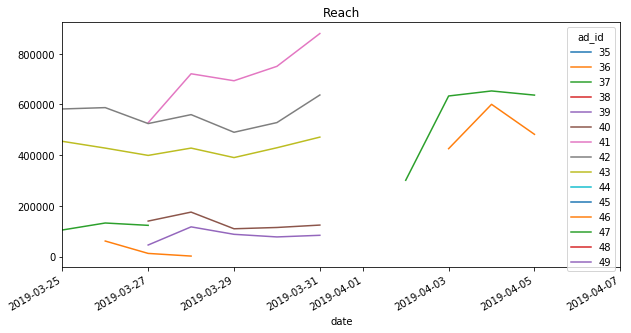

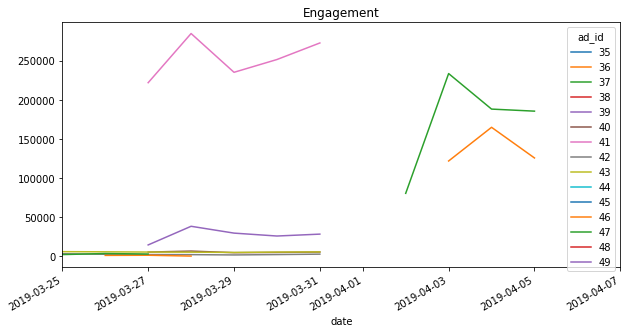

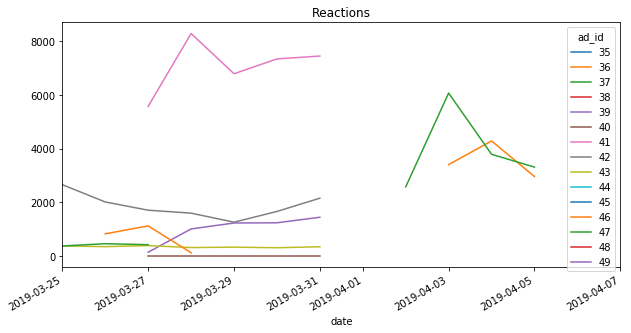

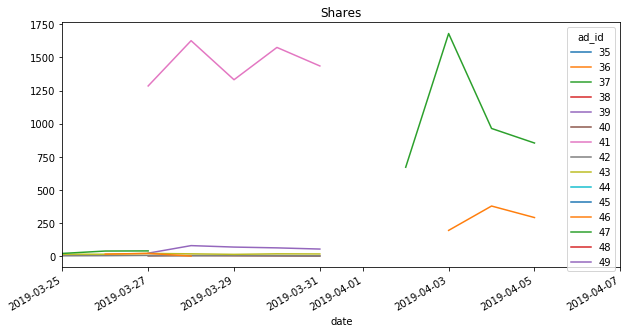

In [22]:
#############
# Exercise 5: using `pandas.DataFrame.plot` show the time series of the four metrics
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
#############
tmp['reach'].plot(figsize=(10,5),title='Reach')
tmp['engagement'].plot(figsize=(10,5),title='Engagement')
tmp['reactions'].plot(figsize=(10,5),title='Reactions')
tmp['shares'].plot(figsize=(10,5),title='Shares')

## Funnels
We create some simple derived quantities showing the funnels as ratio to `reach`. Since we want to show aggregated results, we need to remember to do first the sums over demographic groups, and then calculate the ratios. 
To do so we can use twice `pandas.pivot_table`:

1. The first step is to create a DataFrame with **two** indexes: `date` and `ad_id`. In `pandas` data-frame can have an arbitrary number of indexes. We aggregate (summing) over `age` and `gender`.
2. We then calculate the ratios and create new columns to the new DataFrame
3. We than *reset the index*, with `pandas.reset_index` to transform back `ad_id` and `date` to normal columns.
4. We than make a new pivot table with index only `date`. There is no more the need to specify `aggfunc` because we have already aggregated at the first pivot (summing on gender and age groups)

In [24]:
# Step 1.
############
# Exercise 6: Complete the following code
############
tmp = pd.pivot_table(
    df ,
    index=[ 'date', 'ad_id' ], #You need now a list to have multi-index
    values=['reach','engagement','reactions','shares'],
    aggfunc= np.sum
)
tmp.head()

engagement   reach  reactions  shares
date       ad_id                                       
2019-03-25 42         3132.0  582146     2660.0     2.0
           43         5789.0  454515      378.0    14.0
           47         2036.0  104669      376.0    20.0
2019-03-26 42         2423.0  587457     2016.0     3.0
           43         5589.0  427795      351.0    14.0

In [25]:
# Step 2.
tmp['EtR'] = tmp['engagement']/tmp['reach'] # Engagement/reach
tmp['RtR'] = tmp['reactions']/tmp['reach'] # Reactions/reach
tmp['StR'] = tmp['shares']/tmp['reach'] # Shares/reach
tmp.head()

engagement   reach  reactions  shares       EtR       RtR  \
date       ad_id                                                              
2019-03-25 42         3132.0  582146     2660.0     2.0  0.005380  0.004569   
           43         5789.0  454515      378.0    14.0  0.012737  0.000832   
           47         2036.0  104669      376.0    20.0  0.019452  0.003592   
2019-03-26 42         2423.0  587457     2016.0     3.0  0.004125  0.003432   
           43         5589.0  427795      351.0    14.0  0.013065  0.000820   

                       StR  
date       ad_id            
2019-03-25 42     0.000003  
           43     0.000031  
           47     0.000191  
2019-03-26 42     0.000005  
           43     0.000033

In [26]:
# Step 3.
tmp = tmp.reset_index()
tmp.head()

date  ad_id  engagement   reach  reactions  shares       EtR  \
0 2019-03-25     42      3132.0  582146     2660.0     2.0  0.005380   
1 2019-03-25     43      5789.0  454515      378.0    14.0  0.012737   
2 2019-03-25     47      2036.0  104669      376.0    20.0  0.019452   
3 2019-03-26     42      2423.0  587457     2016.0     3.0  0.004125   
4 2019-03-26     43      5589.0  427795      351.0    14.0  0.013065   

        RtR       StR  
0  0.004569  0.000003  
1  0.000832  0.000031  
2  0.003592  0.000191  
3  0.003432  0.000005  
4  0.000820  0.000033

In [27]:
# Step 4.
tmp = pd.pivot_table(
    tmp,
    index=['date'],
    values=['EtR','RtR','StR'],
    columns=['ad_id']
)
tmp.head()

EtR                                                                \
ad_id       35  36  37  38        39        40        41        42        43   
date                                                                           
2019-03-25 NaN NaN NaN NaN       NaN       NaN       NaN  0.005380  0.012737   
2019-03-26 NaN NaN NaN NaN       NaN       NaN       NaN  0.004125  0.013065   
2019-03-27 NaN NaN NaN NaN  0.316542  0.037482  0.420170  0.003952  0.013230   
2019-03-28 NaN NaN NaN NaN  0.326594  0.037189  0.394828  0.003521  0.011970   
2019-03-29 NaN NaN NaN NaN  0.336544  0.040923  0.339003  0.003211  0.012240   

                      ...       StR                                          \
ad_id             44  ...        40        41        42        43        44   
date                  ...                                                     
2019-03-25       NaN  ...       NaN       NaN  0.000003  0.000031       NaN   
2019-03-26       NaN  ...       NaN       NaN  0.000005  0.000033       NaN   
2019-03-27       NaN  ...  0.000007  0.002434  0.000010  0.000050       NaN   
2019-03-28       NaN  ...  0.000023  0.002257  0.000005  0.000040       NaN   
2019-03-29  0.105005  ...  0.000018  0.001921  0.000010  0.000033  0.001716   

                                                              
ad_id             45        46        47        48        49  
date                                                          
2019-03-25       NaN       NaN  0.000191       NaN       NaN  
2019-03-26       NaN  0.000245  0.000287  0.000445  0.000301  
2019-03-27       NaN  0.001630  0.000317       NaN       NaN  
2019-03-28       NaN  0.000000       NaN       NaN       NaN  
2019-03-29  0.000688       NaN       NaN       NaN       NaN  

[5 rows x 45 columns]

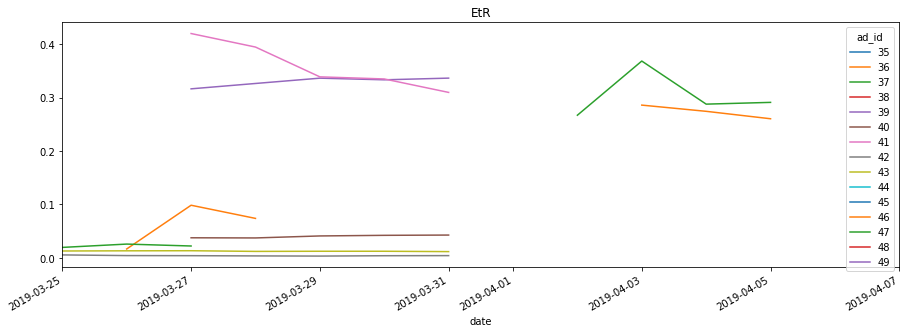

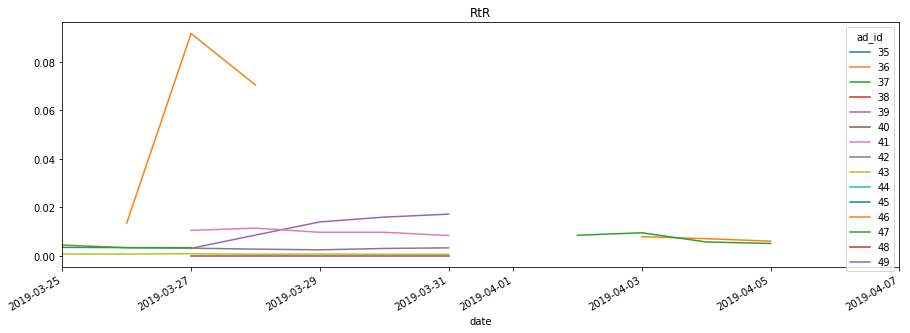

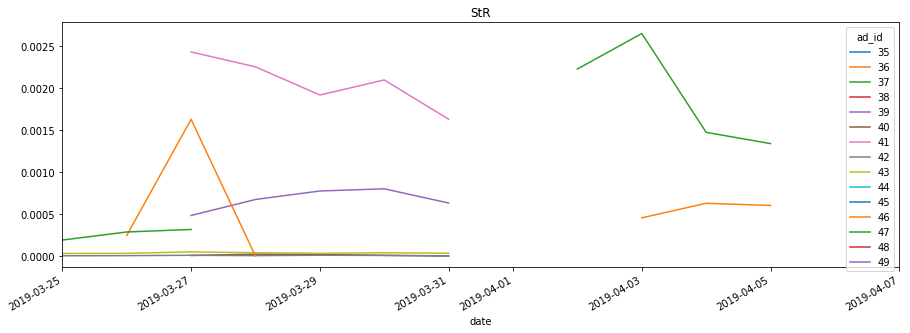

In [30]:
tmp.plot(y='EtR',figsize=(15,5),title='EtR')
tmp.plot(y='RtR',figsize=(15,5),title="RtR")
tmp.plot(y='StR',figsize=(15,5),title="StR")

From these results it is clearly visible that the *reaction to reach* ratio is below 10% and the *share to reach* is well below 1%. These type of numbers seems small but are quite typical for online advertisement. There are few ADs (36, 37, 39, 40) that do significantly better, the advertiser should understand better why and try to replicate the success of them.

# Demographics data

Let's now make a bar chart of the cumulated reach results for age groups and sexes. For this case we aggregate over the advertisements.

In [ ]:
############
# Exercise 7: You are now a guru!
# All alone
tmp = pd.pivot_table(
    df,
    index=['age'],
    values=['reactions','reach','shares','engagement'],
    columns=['gender'],
    aggfunc=np.sum
)
tmp.head()

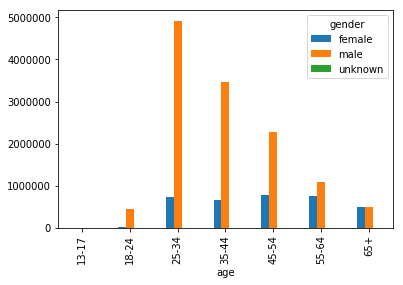

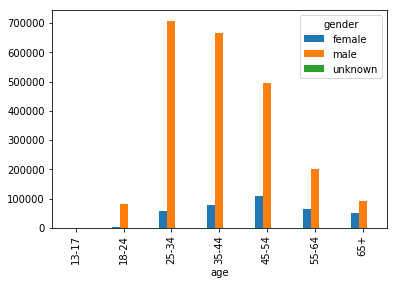

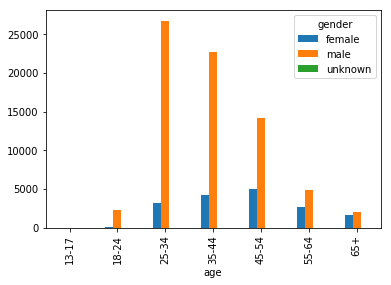

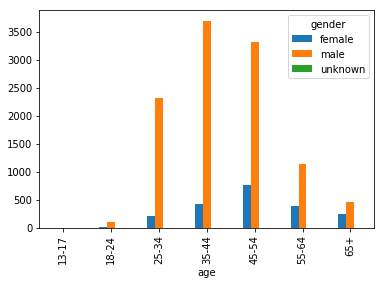

In [37]:
tmp.plot(y='reach',kind='bar')
tmp.plot(y='engagement',kind='bar')
tmp.plot(y='reactions',kind='bar')
tmp.plot(y='shares',kind='bar')

The campaign is clearly targeting male audience. It is interesting to note that the campaign seems to have more success with older men (shares distribution is more symmetric). The skewness of reach is probably due to Facebook demographics.